<a href="https://colab.research.google.com/github/danielaterra/shape-based-CervicalCellsClassifier/blob/main/CRIC_morfo_featureSelection_exp1_Hierarch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Seleção de features morfométricas para núcleo/citoplasma de células cervicais (base CRIC)

In [ ]:
!pip install pyefd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/shape_based_CRIC_Hclassifier")

In [ ]:
import numpy as np
import pandas as pd 
from math import sqrt
import os
import sys
import csv
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis

import pyefd
from pyefd import elliptic_fourier_descriptors, normalize_efd

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import feature_selection as fs

from datetime import datetime

# pay attention to capitalization below!
from spFSR import SpFSR
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE

from itertools import cycle
from random import randint
from random import sample

import xgboost as xgb 

import functions, shapeFeatures


In [ ]:
Bethesda_classes = {'Normal':0, 'ASC-US':1, 'ASC-H':2, 'LSIL':3,'HSIL':4, 'Invasive Carcinoma':5} 
Bethesda_idx_classes = {0: 'Normal', 1:'ASC-US', 2:'ASC-H', 3:'LSIL',4: 'HSIL', 5:'Invasive Carcinoma'} 

In [ ]:
len(functions.list_all_features(20)), len(functions.list_all_nucleus_features(20)), len(functions.list_all_cyto_features(20)), len(functions.list_all_EFD_features(20))

(200, 98, 98, 154)

### Lê arquivo (features):

In [ ]:
N_EFD_COEFFS = 20

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/shape_based_CRIC_Hclassifier/dataCRIC.csv', sep='|', header=0)
df = shapeFeatures.normalize_dataset(df, n_efd_coeffs= N_EFD_COEFFS)
 

In [ ]:
df

,image_id,cell_id,areaN,eccenN,extentN,periN,maxAxN,minAxN,compacN,circuN,...,efdC73,efdC74,efdC75,efdC76,efdC77,ratio_NC,ratio_NC_per,ratio_NC_hArea,nucleus_position,bethesda
0,1.0,14796.0,0.007403,0.606414,0.842276,0.031326,0.036711,0.083827,0.024126,0.863522,...,0.156532,0.321490,0.859931,0.382225,0.302311,0.017236,0.115646,0.016730,0.099098,0.0
1,1.0,14797.0,0.009371,0.541484,0.808102,0.035945,0.039493,0.095649,0.018763,0.891071,...,0.150931,0.317850,0.859539,0.369221,0.299938,0.010656,0.089517,0.010168,0.121456,0.0
2,1.0,14798.0,0.007275,0.313794,0.884418,0.029457,0.025365,0.097062,0.018895,0.890378,...,0.153458,0.315454,0.861978,0.367980,0.302076,0.007400,0.073961,0.006897,0.043773,0.0
3,1.0,14799.0,0.010570,0.489270,0.778201,0.040199,0.040900,0.103428,0.021001,0.879403,...,0.157254,0.319562,0.860312,0.382943,0.303682,0.028309,0.154784,0.027752,0.128927,0.0
4,1.0,14801.0,0.009115,0.296366,0.842276,0.036826,0.031283,0.106376,0.024456,0.861871,...,0.147193,0.314554,0.860292,0.359672,0.300094,0.021569,0.129992,0.020738,0.069245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,399.0,11539.0,0.028927,0.838629,0.579720,0.094256,0.134656,0.118369,0.041270,0.784196,...,0.152113,0.318217,0.859606,0.370535,0.299400,0.206211,0.149094,0.085315,1.943974,5.0
3229,399.0,11540.0,0.025333,0.874227,0.645532,0.094611,0.135676,0.100778,0.064959,0.692461,...,0.150010,0.322108,0.859366,0.375599,0.300755,0.245537,0.247086,0.136756,0.916374,5.0
3230,400.0,11535.0,0.017031,0.910741,0.390863,0.092280,0.136377,0.078990,0.131860,0.507358,...,0.153944,0.319972,0.860379,0.372458,0.303245,0.191508,0.471092,0.188343,0.326252,5.0
3231,400.0,11536.0,0.020797,0.949322,0.528816,0.105709,0.169029,0.065965,0.137720,0.494794,...,0.151898,0.320620,0.859608,0.370771,0.299599,0.111823,0.078186,0.023058,3.177247,5.0


In [ ]:
# Separa dados por classe de maneira balanceada:
data_normal = df[df['bethesda'] == 0].copy()
data_normal.set_index((i for i in range(data_normal.shape[0])), inplace=True)

data_ascus = df[df['bethesda'] == 1].copy()
data_ascus.set_index((i for i in range(data_ascus.shape[0])), inplace=True)

data_asch = df[df['bethesda'] == 2].copy()
data_asch.set_index((i for i in range(data_asch.shape[0])), inplace=True)

data_lsil = df[df['bethesda'] == 3].copy()
data_lsil.set_index((i for i in range(data_lsil.shape[0])), inplace=True)

data_hsil = df[df['bethesda'] == 4].copy()
data_hsil.set_index((i for i in range(data_hsil.shape[0])), inplace=True)

data_car = df[df['bethesda'] == 5].copy()
data_car.set_index((i for i in range(data_car.shape[0])), inplace=True)

print("--- Totais por classe --- ")               
print("Normal...: ", data_normal.values.shape[0])               
print("ASC-Us...: ", data_ascus.values.shape[0])               
print("ASC-H....: ", data_asch.values.shape[0])               
print("LSIL.....: ", data_lsil.values.shape[0])               
print("HSIL.....: ", data_hsil.values.shape[0])               
print("Carcinoma: ", data_car.values.shape[0]) 
 

--- Totais por classe --- 
Normal...:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
Carcinoma:  77


#### Gera dataframes: dados (data), classes (target) e Ids (image/cell)

In [ ]:
# Monta base (data, target, image/cells ids)
data, target, image_cells_ids= functions.get_database_data_targe_ids(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       functions.list_all_features(N_EFD_COEFFS))
 

## Features selection - experiment nº1:  (nucleus + cytoplasm)

In [ ]:
features_desc = "Selected features to nucleus and cytoplasm"
N_FEATURES = 30
N_ITER = 10

## Dicts feature importances (stats):
features = functions.list_all_features(N_EFD_COEFFS) 
aux = [0.0 for i in features]
features_importance_dict_spfsr_1 = dict(zip(features, aux))
features_importance_dict_spfsr_2 = dict(zip(features, aux))
features_importance_dict_spfsr_3 = dict(zip(features, aux))
features_importance_dict_spfsr_4 = dict(zip(features, aux))

features_importance_dict_mi_1 = dict(zip(features, aux))
features_importance_dict_mi_2 = dict(zip(features, aux))
features_importance_dict_mi_3 = dict(zip(features, aux))
features_importance_dict_mi_4 = dict(zip(features, aux))
start_time = functions.timer()


In [ ]:
# Loop principal:

for it in range(N_ITER):
    print('Iteração número: ', it)

    # Separa dados para treino/validação e teste:
    (X_train, X_test, y_train, y_test, image_cells_ids_train, image_cells_ids_test) = train_test_split(data, target, image_cells_ids, test_size=0.2)

    X_train = X_train[features]

    #### Seleção de características:  classificadores (1, 2, 3, 4)
    best_features_MI_1, feature_importances_MI_1 = functions.features_selection_mi(*functions.filter_dataXY(X_train, y_train, cls_type=1), N_features= N_FEATURES)
    best_features_spfsr_1, feature_importances_spfsr_1 = functions.features_selection_spfsr(*functions.filter_dataXY(X_train, y_train, cls_type=1), N_features= 0)
    best_features_MI_2, feature_importances_MI_2 = functions.features_selection_mi(*functions.filter_dataXY(X_train, y_train, cls_type=2), N_features= N_FEATURES)
    best_features_spfsr_2, feature_importances_spfsr_2 = functions.features_selection_spfsr(*functions.filter_dataXY(X_train, y_train, cls_type=2), N_features= 0)
    best_features_MI_3, feature_importances_MI_3 = functions.features_selection_mi(*functions.filter_dataXY(X_train, y_train, cls_type=3), N_features= N_FEATURES)
    best_features_spfsr_3, feature_importances_spfsr_3 = functions.features_selection_spfsr(*functions.filter_dataXY(X_train, y_train, cls_type=3), N_features= 0)
    best_features_MI_4, feature_importances_MI_4 = functions.features_selection_mi(*functions.filter_dataXY(X_train, y_train, cls_type=4), N_features = N_FEATURES)
    best_features_spfsr_4, feature_importances_spfsr_4 = functions.features_selection_spfsr(*functions.filter_dataXY(X_train, y_train, cls_type=4), N_features= 0)

    ### Acumula seleções:   
    features_importance_dict_spfsr_1 = functions.acum_feature_importances(best_features_spfsr_1, feature_importances_spfsr_1, features_importance_dict_spfsr_1)    
    features_importance_dict_spfsr_2 = functions.acum_feature_importances(best_features_spfsr_2, feature_importances_spfsr_2, features_importance_dict_spfsr_2)    
    features_importance_dict_spfsr_3 = functions.acum_feature_importances(best_features_spfsr_3, feature_importances_spfsr_3, features_importance_dict_spfsr_3)    
    features_importance_dict_spfsr_4 = functions.acum_feature_importances(best_features_spfsr_4, feature_importances_spfsr_4, features_importance_dict_spfsr_4)    
    features_importance_dict_mi_1 = functions.acum_feature_importances(best_features_MI_1, feature_importances_MI_1, features_importance_dict_mi_1)    
    features_importance_dict_mi_2 = functions.acum_feature_importances(best_features_MI_2, feature_importances_MI_2, features_importance_dict_mi_2)    
    features_importance_dict_mi_3 = functions.acum_feature_importances(best_features_MI_3, feature_importances_MI_3, features_importance_dict_mi_3)    
    features_importance_dict_mi_4 = functions.acum_feature_importances(best_features_MI_4, feature_importances_MI_4, features_importance_dict_mi_4)    


functions.timer(start_time)
## Finaliza seleções:
selected_features_spfsr_1, selected_features_scores_spfsr_1 = functions.resume_feature_importance(features_importance_dict_spfsr_1, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_spfsr_2, selected_features_scores_spfsr_2 = functions.resume_feature_importance(features_importance_dict_spfsr_2, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_spfsr_3, selected_features_scores_spfsr_3 = functions.resume_feature_importance(features_importance_dict_spfsr_3, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_spfsr_4, selected_features_scores_spfsr_4 = functions.resume_feature_importance(features_importance_dict_spfsr_4, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_mi_1, selected_features_scores_mi_1 = functions.resume_feature_importance(features_importance_dict_mi_1, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_mi_2, selected_features_scores_mi_2 = functions.resume_feature_importance(features_importance_dict_mi_2, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_mi_3, selected_features_scores_mi_3 = functions.resume_feature_importance(features_importance_dict_mi_3, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_mi_4, selected_features_scores_mi_4 = functions.resume_feature_importance(features_importance_dict_mi_4, N_iter=N_ITER, N_features= N_FEATURES)

## Imprime features selecionadas:
print("1.MI\n",selected_features_mi_1, selected_features_scores_mi_1)
print("2.MI\n",selected_features_mi_2, selected_features_scores_mi_2)
print("3.MI\n",selected_features_mi_3, selected_features_scores_mi_3)
print("4.MI\n",selected_features_mi_4, selected_features_scores_mi_4)

print("1.SPFSR\n",selected_features_spfsr_1, selected_features_scores_spfsr_1)
print("2.SPFSR\n",selected_features_spfsr_2, selected_features_scores_spfsr_2)
print("3.SPFSR\n",selected_features_spfsr_3, selected_features_scores_spfsr_3)
print("4.SPFSR\n",selected_features_spfsr_4, selected_features_scores_spfsr_4)


Iteração número:  0


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 4
INFO:SpFSR:Number of jobs: 4
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 0
INFO:SpFSR:Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_

Iteração número:  1


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 4
INFO:SpFSR:Number of jobs: 4
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 0
INFO:SpFSR:Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_

Iteração número:  2


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 4
INFO:SpFSR:Number of jobs: 4
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 0
INFO:SpFSR:Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_

Iteração número:  3


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 4
INFO:SpFSR:Number of jobs: 4
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 0
INFO:SpFSR:Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_

Iteração número:  4


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 4
INFO:SpFSR:Number of jobs: 4
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 0
INFO:SpFSR:Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_

Iteração número:  5


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 4
INFO:SpFSR:Number of jobs: 4
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 0
INFO:SpFSR:Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_

Iteração número:  6


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 4
INFO:SpFSR:Number of jobs: 4
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 0
INFO:SpFSR:Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_

Iteração número:  7


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 4
INFO:SpFSR:Number of jobs: 4
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 0
INFO:SpFSR:Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_

Iteração número:  8


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 4
INFO:SpFSR:Number of jobs: 4
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 0
INFO:SpFSR:Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_

Iteração número:  9


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 4
INFO:SpFSR:Number of jobs: 4
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 0
INFO:SpFSR:Number of features to select: 0
SpFSR-INFO: iter_no: 0, num_


 Time taken: 0 hours 38 minutes and 19.03 seconds.
1.MI
 ['ratio_NC' 'ratio_NC_per' 'ratio_NC_hArea' 'mrdN' 'eN' 'maxAxN' 'periN'
 'ardN' 'hAreaN' 'areaN' 'equidiaN' 'compacC' 'circuC' 'fdN' 'riN' 'areaC'
 'periC' 'hAreaC' 'fdC' 'minAxC' 'mrdC' 'maxAxC' 'eC' 'ardC' 'equidiaC'
 'compacN' 'circuN' 'riC' 'minAxN' 'convexN'] [0.402466   0.4002666  0.39533928 0.3237488  0.3192293  0.30533117
 0.2839315  0.2789814  0.24461262 0.23932233 0.23779823 0.23002705
 0.22993411 0.22753973 0.21637106 0.20804143 0.19175433 0.18839094
 0.18404377 0.18381815 0.18293928 0.18196207 0.1806529  0.1801142
 0.17905632 0.17628035 0.17627048 0.17159423 0.14637674 0.08047137]
2.MI
 ['areaC' 'equidiaC' 'fdC' 'hAreaC' 'periC' 'ardC' 'ratio_NC_hArea'
 'ratio_NC' 'maxAxC' 'mrdC' 'eC' 'ratio_NC_per' 'riC' 'minAxC' 'circuC'
 'compacC' 'areaN' 'equidiaN' 'fdN' 'hAreaN' 'riN' 'periN' 'ardN' 'minAxN'
 'nucleus_position' 'solidC' 'maxAxN' 'extentC' 'eN' 'mrdN'] [0.58426297 0.5660377  0.56301117 0.55612415 0.5561225  0.55

In [ ]:
print("1.MI\n",len(selected_features_mi_1), len(selected_features_scores_mi_1))
print("2.MI\n",len(selected_features_mi_2), len(selected_features_scores_mi_2))
print("3.MI\n",len(selected_features_mi_3), len(selected_features_scores_mi_3))
print("4.MI\n",len(selected_features_mi_4), len(selected_features_scores_mi_4))

print("1.SPFSR\n",len(selected_features_spfsr_1), len(selected_features_scores_spfsr_1))
print("2.SPFSR\n",len(selected_features_spfsr_2), len(selected_features_scores_spfsr_2))
print("3.SPFSR\n",len(selected_features_spfsr_3), len(selected_features_scores_spfsr_3))
print("4.SPFSR\n",len(selected_features_spfsr_4), len(selected_features_scores_spfsr_4))



1.MI
 30 30
2.MI
 30 30
3.MI
 30 30
4.MI
 30 30
1.SPFSR
 30 30
2.SPFSR
 30 30
3.SPFSR
 30 30
4.SPFSR
 30 30


In [ ]:
## Imprime features selecionadas:
print("1.MI\n",selected_features_mi_1, selected_features_scores_mi_1)
print("2.MI\n",selected_features_mi_2, selected_features_scores_mi_2)
print("3.MI\n",selected_features_mi_3, selected_features_scores_mi_3)
print("4.MI\n",selected_features_mi_4, selected_features_scores_mi_4)

print("1.SPFSR\n",selected_features_spfsr_1, selected_features_scores_spfsr_1)
print("2.SPFSR\n",selected_features_spfsr_2, selected_features_scores_spfsr_2)
print("3.SPFSR\n",selected_features_spfsr_3, selected_features_scores_spfsr_3)
print("4.SPFSR\n",selected_features_spfsr_4, selected_features_scores_spfsr_4)

1.MI
 ['ratio_NC' 'ratio_NC_per' 'ratio_NC_hArea' 'mrdN' 'eN' 'maxAxN' 'periN'
 'ardN' 'hAreaN' 'areaN' 'equidiaN' 'compacC' 'circuC' 'fdN' 'riN' 'areaC'
 'periC' 'hAreaC' 'fdC' 'minAxC' 'mrdC' 'maxAxC' 'eC' 'ardC' 'equidiaC'
 'compacN' 'circuN' 'riC' 'minAxN' 'convexN'] [0.402466   0.4002666  0.39533928 0.3237488  0.3192293  0.30533117
 0.2839315  0.2789814  0.24461262 0.23932233 0.23779823 0.23002705
 0.22993411 0.22753973 0.21637106 0.20804143 0.19175433 0.18839094
 0.18404377 0.18381815 0.18293928 0.18196207 0.1806529  0.1801142
 0.17905632 0.17628035 0.17627048 0.17159423 0.14637674 0.08047137]
2.MI
 ['areaC' 'equidiaC' 'fdC' 'hAreaC' 'periC' 'ardC' 'ratio_NC_hArea'
 'ratio_NC' 'maxAxC' 'mrdC' 'eC' 'ratio_NC_per' 'riC' 'minAxC' 'circuC'
 'compacC' 'areaN' 'equidiaN' 'fdN' 'hAreaN' 'riN' 'periN' 'ardN' 'minAxN'
 'nucleus_position' 'solidC' 'maxAxN' 'extentC' 'eN' 'mrdN'] [0.58426297 0.5660377  0.56301117 0.55612415 0.5561225  0.55491024
 0.54633355 0.5424691  0.5413948  0.54029787 

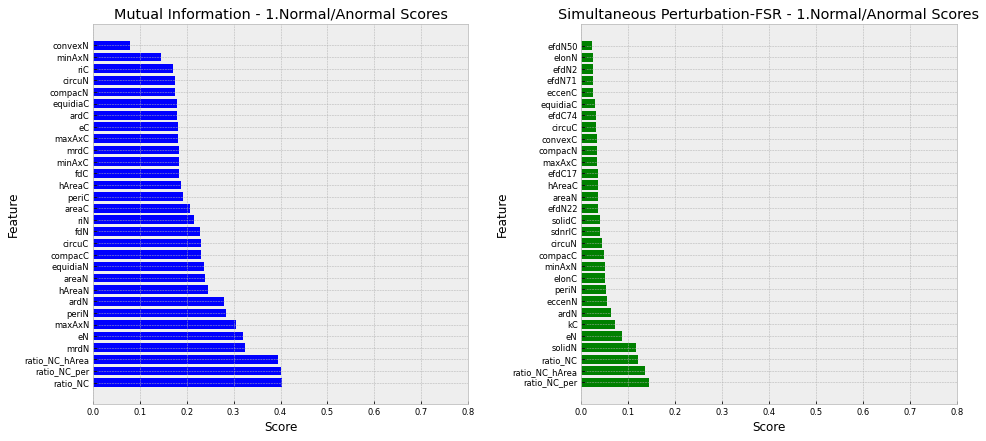

In [ ]:
functions.plot_imp(selected_features_mi_1, selected_features_scores_mi_1, 'Mutual Information - 1.Normal/Anormal', 
         selected_features_spfsr_1, selected_features_scores_spfsr_1, 'Simultaneous Perturbation-FSR - 1.Normal/Anormal') # 

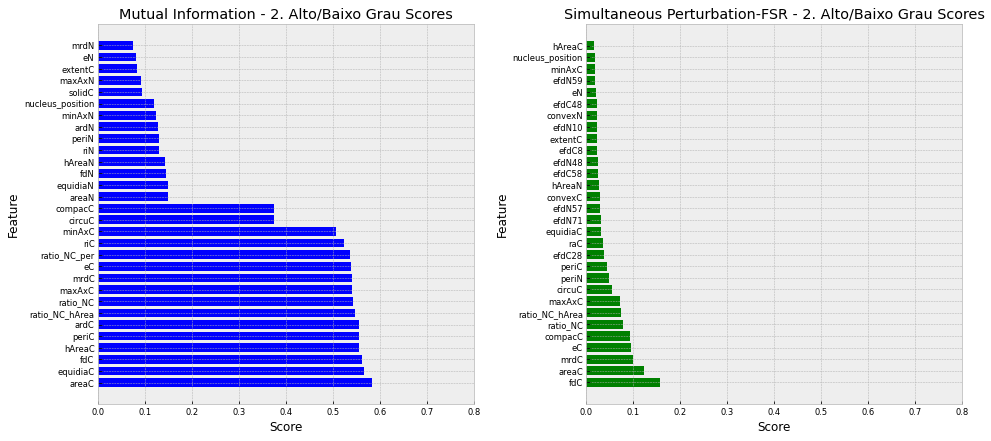

In [ ]:
functions.plot_imp(selected_features_mi_2, selected_features_scores_mi_2, 'Mutual Information - 2. Alto/Baixo Grau', 
         selected_features_spfsr_2, selected_features_scores_spfsr_2, 'Simultaneous Perturbation-FSR - 2. Alto/Baixo Grau') # 

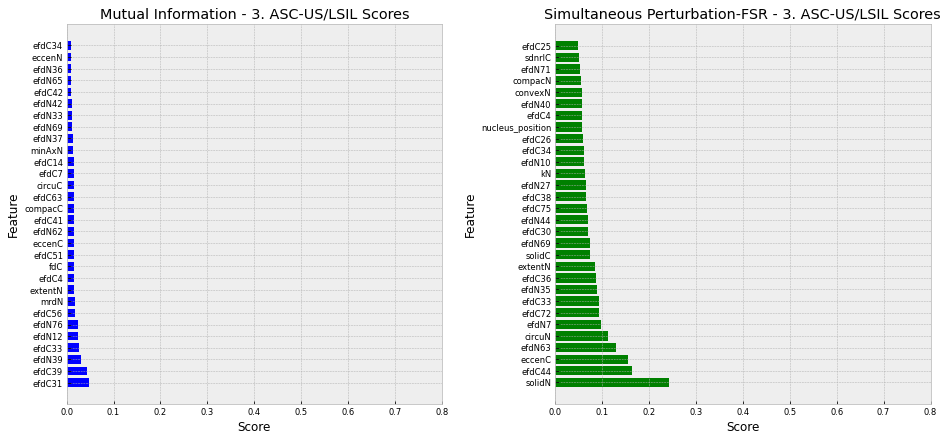

In [ ]:
functions.plot_imp(selected_features_mi_3, selected_features_scores_mi_3, 'Mutual Information - 3. ASC-US/LSIL', 
         selected_features_spfsr_3, selected_features_scores_spfsr_3, 'Simultaneous Perturbation-FSR - 3. ASC-US/LSIL') # 

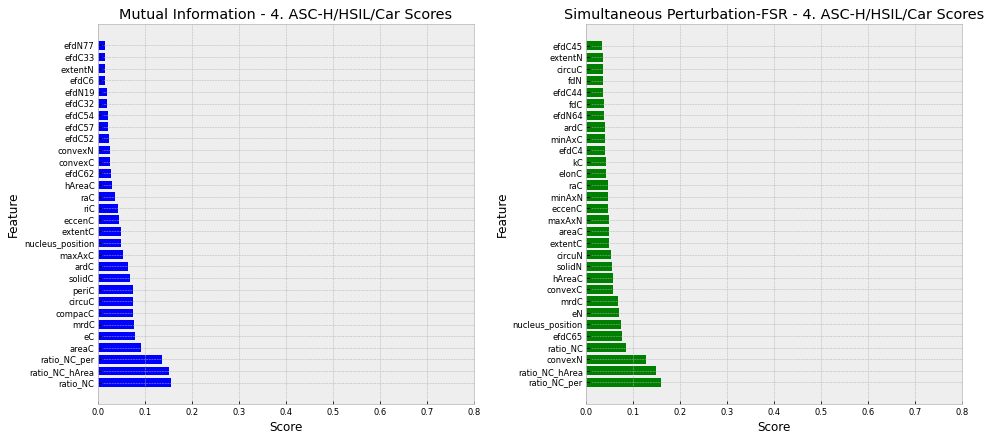

In [ ]:
functions.plot_imp(selected_features_mi_4, selected_features_scores_mi_4, 'Mutual Information - 4. ASC-H/HSIL/Car', 
         selected_features_spfsr_4, selected_features_scores_spfsr_4, 'Simultaneous Perturbation-FSR - 4. ASC-H/HSIL/Car') # 